In [1]:
# imports & device configuration
import os
import re
import html
import itertools as it
import pickle
import hashlib
import warnings
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.autograd import Function
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib import cm

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    default_data_collator,
    EarlyStoppingCallback
)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from scipy.stats import ks_2samp, binomtest
from tqdm.auto import tqdm

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
tqdm.pandas(disable=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cpu


In [2]:
# Path definitions
dict_path = "dataset/FullDictionaries.csv"
amazon_appliances_path = "dataset/amazon_Appliances_5_jiadian.json"
amazon_fashion_path    = "dataset/AMAZON_FASHION_5_shishang.json"
amazon_beauty_path     = "dataset/All_Beauty_5_meizhuang.json"
amazon_pet_path        = "dataset/Pet_Supplies_5_sampled_2.json"
movie_path             = "dataset/Movie Reviews_train.tsv"
twitter1_path          = "dataset/train-twitter.tsv"
twitter2_path          = "dataset/test-twitter.tsv"

DRIVE_PATH = "output"
os.makedirs(DRIVE_PATH, exist_ok=True)

In [3]:
# Load Prepared Datasets

in_path = os.path.join(DRIVE_PATH, "datasets_prepared.pkl")
with open(in_path, "rb") as f:
    datasets = pickle.load(f)

In [4]:
# Load Train / Val / Test Splits

META_PATH = os.path.join(DRIVE_PATH, "all_results_meta.pkl")

if os.path.exists(META_PATH):
    with open(META_PATH, "rb") as f:
        all_results = pickle.load(f)

    for res in all_results.values():
        res["train_idx"] = np.array(res["train_idx"])
        res["val_idx"]   = np.array(res["val_idx"])
        res["test_idx"]   = np.array(res["test_idx"])
    print("all_results restored – keys:", list(all_results.keys()))
else:
    print("meta file not found")
    all_results = {}



all_results restored – keys: ['Amazon', 'Movie', 'Twitter']



=== Amazon ===


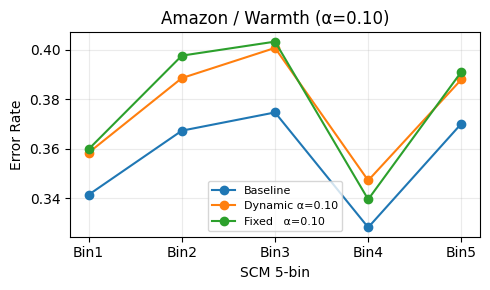

saved Amazon_warmth_alpha0.10.png


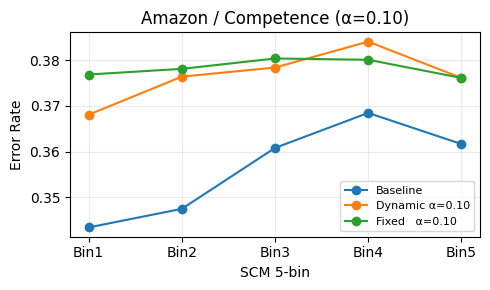

saved Amazon_competence_alpha0.10.png


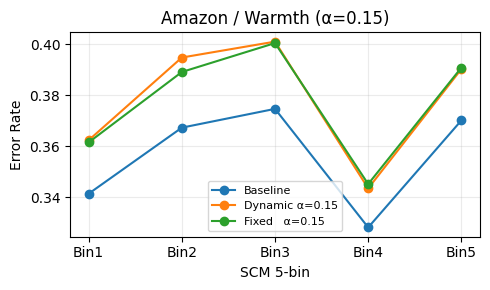

saved Amazon_warmth_alpha0.15.png


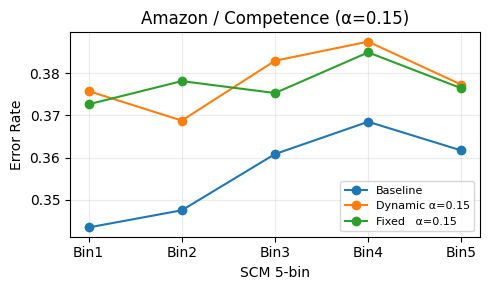

saved Amazon_competence_alpha0.15.png


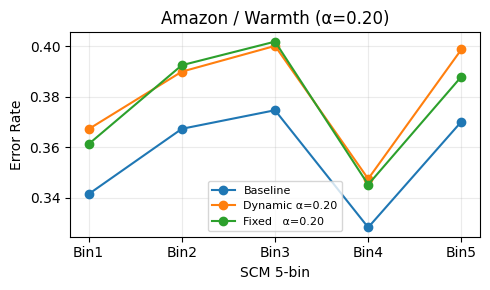

saved Amazon_warmth_alpha0.20.png


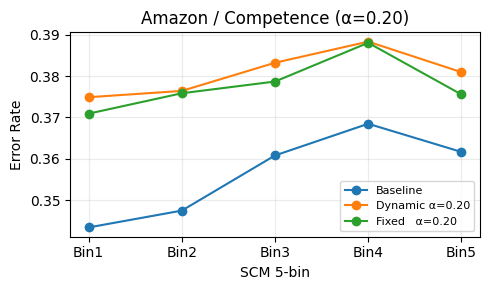

saved Amazon_competence_alpha0.20.png


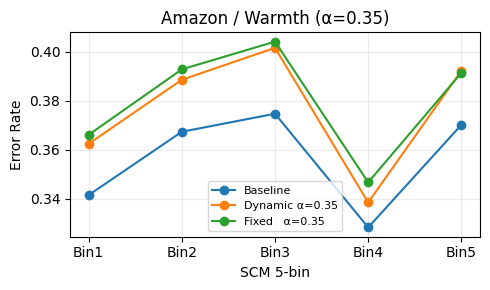

saved Amazon_warmth_alpha0.35.png


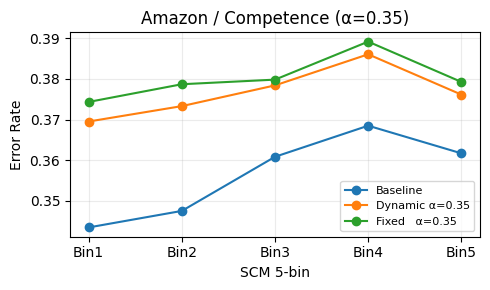

saved Amazon_competence_alpha0.35.png


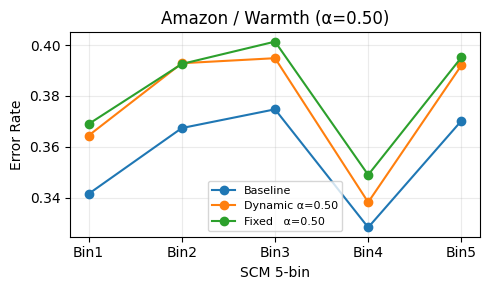

saved Amazon_warmth_alpha0.50.png


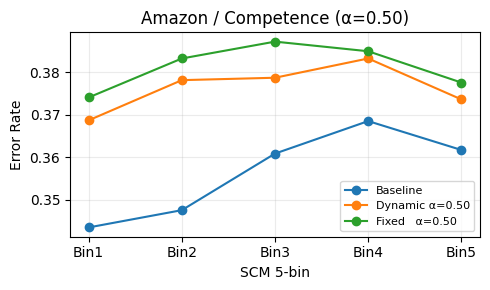

saved Amazon_competence_alpha0.50.png

=== Movie ===


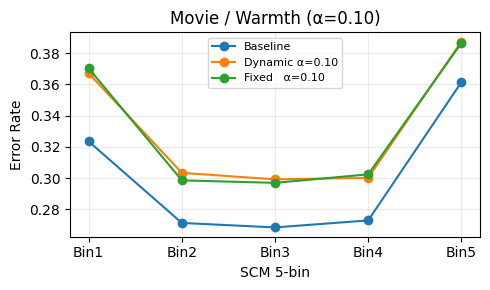

saved Movie_warmth_alpha0.10.png


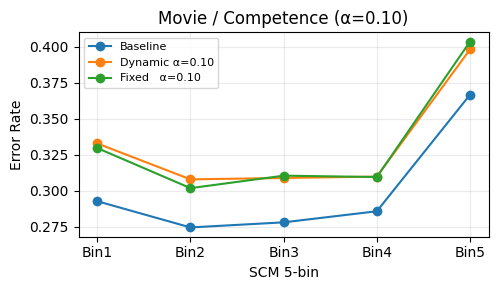

saved Movie_competence_alpha0.10.png


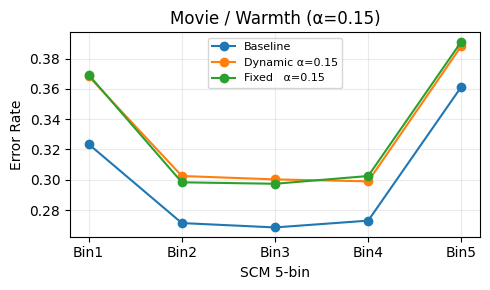

saved Movie_warmth_alpha0.15.png


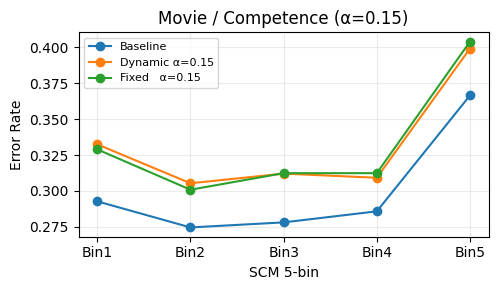

saved Movie_competence_alpha0.15.png


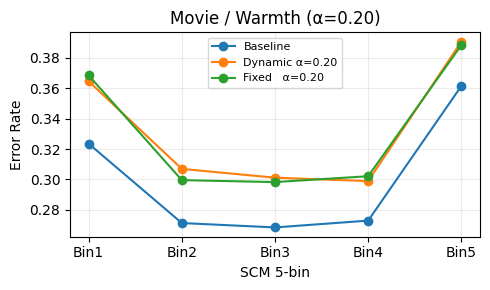

saved Movie_warmth_alpha0.20.png


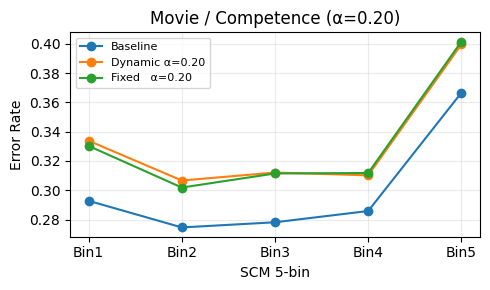

saved Movie_competence_alpha0.20.png


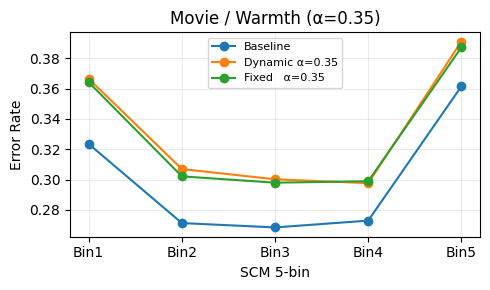

saved Movie_warmth_alpha0.35.png


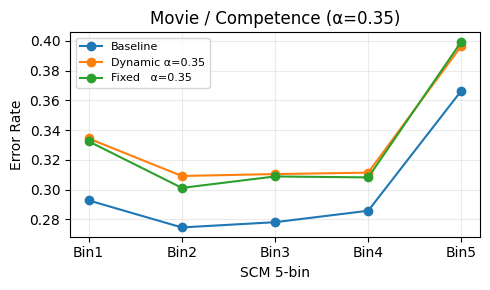

saved Movie_competence_alpha0.35.png


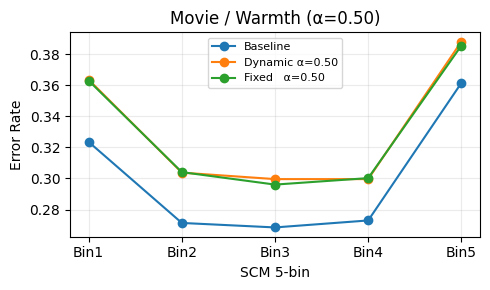

saved Movie_warmth_alpha0.50.png


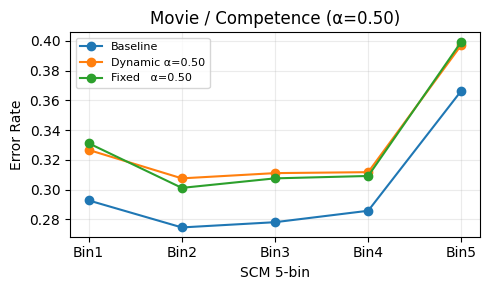

saved Movie_competence_alpha0.50.png

=== Twitter ===


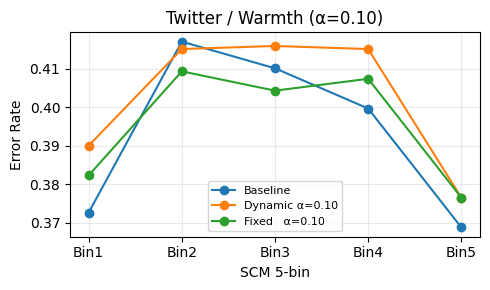

saved Twitter_warmth_alpha0.10.png


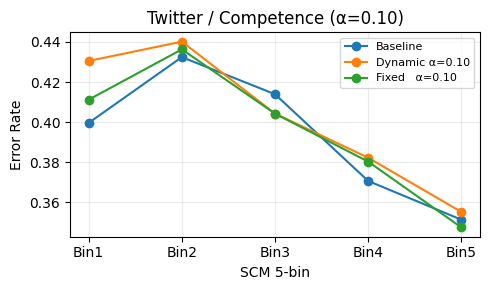

saved Twitter_competence_alpha0.10.png


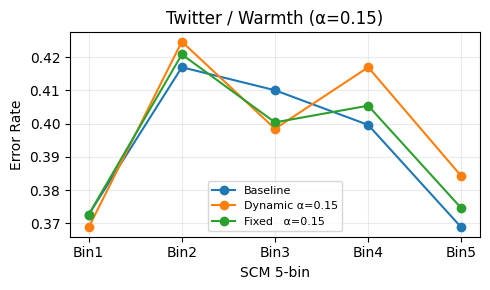

saved Twitter_warmth_alpha0.15.png


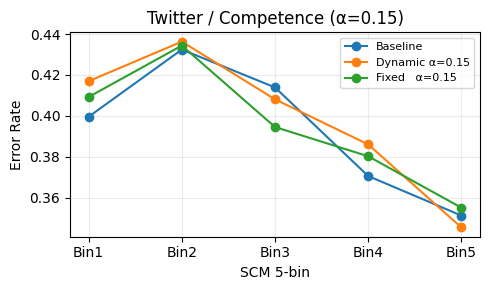

saved Twitter_competence_alpha0.15.png


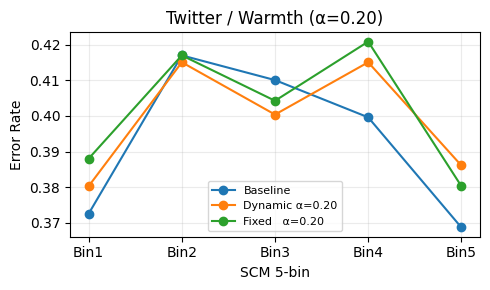

saved Twitter_warmth_alpha0.20.png


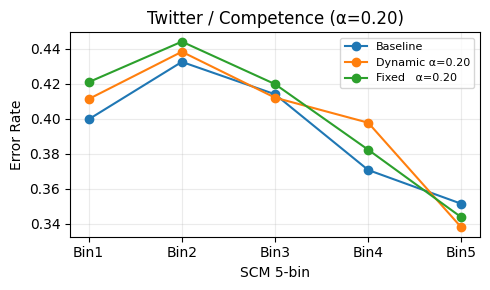

saved Twitter_competence_alpha0.20.png


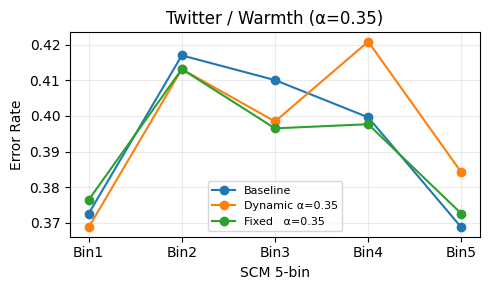

saved Twitter_warmth_alpha0.35.png


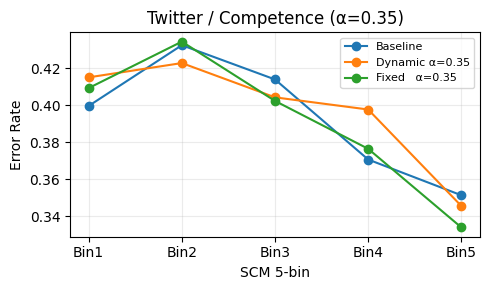

saved Twitter_competence_alpha0.35.png


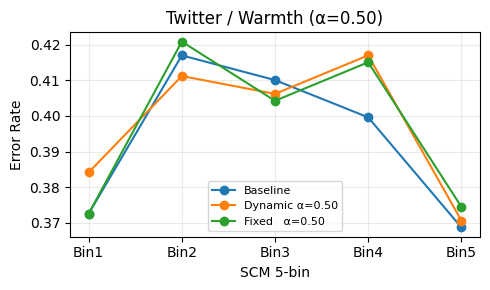

saved Twitter_warmth_alpha0.50.png


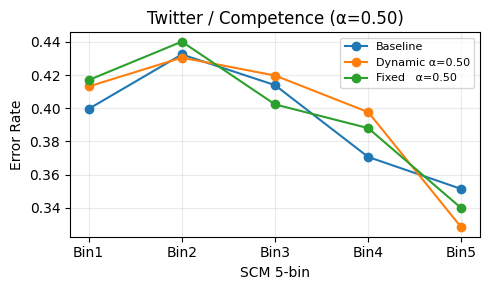

saved Twitter_competence_alpha0.50.png


In [ ]:
# Triple-curve Diagnostics
BASE_CKPT  = {
    "Amazon" : f"{DRIVE_PATH}/results_Amazon_ep2/checkpoint-2206",
    "Movie"  : f"{DRIVE_PATH}/results_Movie_ep3/checkpoint-2928",
    "Twitter": f"{DRIVE_PATH}/results_Twitter_ep5/checkpoint-810",
}
DATASETS   = ["Amazon", "Movie", "Twitter"]
AXES       = ["warmth_scm", "competence_scm"]
GRID_ALPHA = [0.10, 0.15, 0.20, 0.35, 0.50]

MAX_LEN   = 128
BATCH_SZ  = 512
SAVE_DIR  = os.path.join(DRIVE_PATH, "fig_compare")
os.makedirs(SAVE_DIR, exist_ok=True)

# Return the path to the most recent checkpoint-xxxx subfolder
def latest_ckpt(folder: str) -> str:
    kids = [d for d in os.listdir(folder) if re.fullmatch(r"checkpoint-\d+", d)]
    if not kids:
        raise FileNotFoundError(f"[no checkpoint-*] {folder}")
    return os.path.join(folder, sorted(kids, key=lambda s: int(s.split('-')[1]))[-1])

@torch.inference_mode()
# Given a model and tokenizer, run inference on a list of texts, returns numpy array of logits.
def logits_for_ckpt(model, tok, texts, fp16=True, pad_max=False):
    collate = lambda xs: tok(xs,
                             truncation=True,
                             padding="max_length" if pad_max else True,
                             max_length=MAX_LEN,
                             return_tensors="pt")
    loader = DataLoader(texts, batch_size=BATCH_SZ,
                        shuffle=False, collate_fn=collate, pin_memory=True)
    outs = []
    ctx = torch.amp.autocast("cuda", dtype=torch.float16) if (fp16 and DEVICE.type=="cuda") else torch.no_grad()
    with ctx:
        for bt in loader:
            bt = {k: v.to(DEVICE) for k, v in bt.items()}
            outs.append(model(**bt).logits.cpu())
    return torch.cat(outs).numpy()

def err_vec(logits, labels):
    return (logits.argmax(-1) != labels).astype(int)


err_cache = {}

def get_err(ds, tag, ckpt_path, tok, texts, labels):
    if (ds, tag) in err_cache:
        return err_cache[(ds, tag)]
    model  = AutoModelForSequenceClassification.from_pretrained(ckpt_path).to(DEVICE)
    logits = logits_for_ckpt(model, tok, texts, fp16=True)
    errs   = err_vec(logits, labels)
    err_cache[(ds, tag)] = errs
    del model; torch.cuda.empty_cache()
    return errs

for ds in DATASETS:
    print(f"\n=== {ds} ===")
    tok    = AutoTokenizer.from_pretrained(BASE_CKPT[ds], use_fast=True, local_files_only=True)
    df     = datasets[ds]["df"];     txt_col = datasets[ds]["text_col"]
    vidx   = all_results[ds]["test_idx"]
    texts  = df.loc[vidx, txt_col].fillna("").astype(str).tolist()
    labels = (df.loc[vidx, "label_5class"] - 1).values

    # Compute baseline error vector
    err_b = get_err(ds, "Baseline", BASE_CKPT[ds], tok, texts, labels)

    # Precompute 5 quantile bins for each SCM axis on test set
    bin_cache = {}
    for axis in AXES:
        ranks            = df.loc[vidx, axis].rank(method="first")
        bin_cache[axis]  = pd.qcut(ranks, 5, labels=False, duplicates="drop")

    for alpha in GRID_ALPHA:
        tag = f"a{int(alpha*100):03d}"
        dy_dir = f"{DRIVE_PATH}/results_debiased_{ds}_{tag}"
        fx_dir = f"{DRIVE_PATH}/results_debiased_{ds}_fixed_{tag}"
        if not (os.path.isdir(dy_dir) and os.path.isdir(fx_dir)):
            print(f"[skip] {ds} α={alpha:.2f} (folders missing)")
            continue

        err_dy = get_err(ds, tag,       latest_ckpt(dy_dir), tok, texts, labels)
        err_fx = get_err(ds, "fixed_"+tag, latest_ckpt(fx_dir), tok, texts, labels)

        for axis in AXES:
            bins = bin_cache[axis]
            xs   = np.sort(bins.unique())
            e_b  = pd.Series(err_b , index=bins).groupby(level=0).mean().values
            e_dy = pd.Series(err_dy, index=bins).groupby(level=0).mean().values
            e_fx = pd.Series(err_fx, index=bins).groupby(level=0).mean().values

            plt.figure(figsize=(5,3))
            plt.plot(xs, e_b , "-o", label="Baseline")
            plt.plot(xs, e_dy, "-o", label=f"Dynamic α={alpha:.2f}")
            plt.plot(xs, e_fx, "-o", label=f"Fixed   α={alpha:.2f}")
            plt.xticks(xs, [f"Bin{i+1}" for i in xs])
            plt.ylabel("Error Rate"); plt.xlabel("SCM 5-bin")
            plt.title(f"{ds} / {axis.split('_')[0].title()} (α={alpha:.2f})")
            plt.grid(alpha=.25); plt.legend(fontsize=8); plt.tight_layout()

            fig_name = f"{ds}_{axis.split('_')[0]}_alpha{alpha:.2f}.png"
            plt.savefig(os.path.join(SAVE_DIR, fig_name), dpi=300)
            plt.show(); print("saved", fig_name)


Datasets:   0%|          | 0/3 [00:00<?, ?it/s]

infer-batch:   0%|          | 0/35 [00:00<?, ?it/s]

Amazon variants:   0%|          | 0/10 [00:00<?, ?it/s]

infer-batch:   0%|          | 0/35 [00:00<?, ?it/s]

infer-batch:   0%|          | 0/35 [00:00<?, ?it/s]

infer-batch:   0%|          | 0/35 [00:00<?, ?it/s]

infer-batch:   0%|          | 0/35 [00:00<?, ?it/s]

infer-batch:   0%|          | 0/35 [00:00<?, ?it/s]

infer-batch:   0%|          | 0/35 [00:00<?, ?it/s]

infer-batch:   0%|          | 0/35 [00:00<?, ?it/s]

infer-batch:   0%|          | 0/35 [00:00<?, ?it/s]

infer-batch:   0%|          | 0/35 [00:00<?, ?it/s]

infer-batch:   0%|          | 0/35 [00:00<?, ?it/s]

infer-batch:   0%|          | 0/31 [00:00<?, ?it/s]

Movie variants:   0%|          | 0/10 [00:00<?, ?it/s]

infer-batch:   0%|          | 0/31 [00:00<?, ?it/s]

infer-batch:   0%|          | 0/31 [00:00<?, ?it/s]

infer-batch:   0%|          | 0/31 [00:00<?, ?it/s]

infer-batch:   0%|          | 0/31 [00:00<?, ?it/s]

infer-batch:   0%|          | 0/31 [00:00<?, ?it/s]

infer-batch:   0%|          | 0/31 [00:00<?, ?it/s]

infer-batch:   0%|          | 0/31 [00:00<?, ?it/s]

infer-batch:   0%|          | 0/31 [00:00<?, ?it/s]

infer-batch:   0%|          | 0/31 [00:00<?, ?it/s]

infer-batch:   0%|          | 0/31 [00:00<?, ?it/s]

infer-batch:   0%|          | 0/6 [00:00<?, ?it/s]

Twitter variants:   0%|          | 0/10 [00:00<?, ?it/s]

infer-batch:   0%|          | 0/6 [00:00<?, ?it/s]

infer-batch:   0%|          | 0/6 [00:00<?, ?it/s]

infer-batch:   0%|          | 0/6 [00:00<?, ?it/s]

infer-batch:   0%|          | 0/6 [00:00<?, ?it/s]

infer-batch:   0%|          | 0/6 [00:00<?, ?it/s]

infer-batch:   0%|          | 0/6 [00:00<?, ?it/s]

infer-batch:   0%|          | 0/6 [00:00<?, ?it/s]

infer-batch:   0%|          | 0/6 [00:00<?, ?it/s]

infer-batch:   0%|          | 0/6 [00:00<?, ?it/s]

infer-batch:   0%|          | 0/6 [00:00<?, ?it/s]

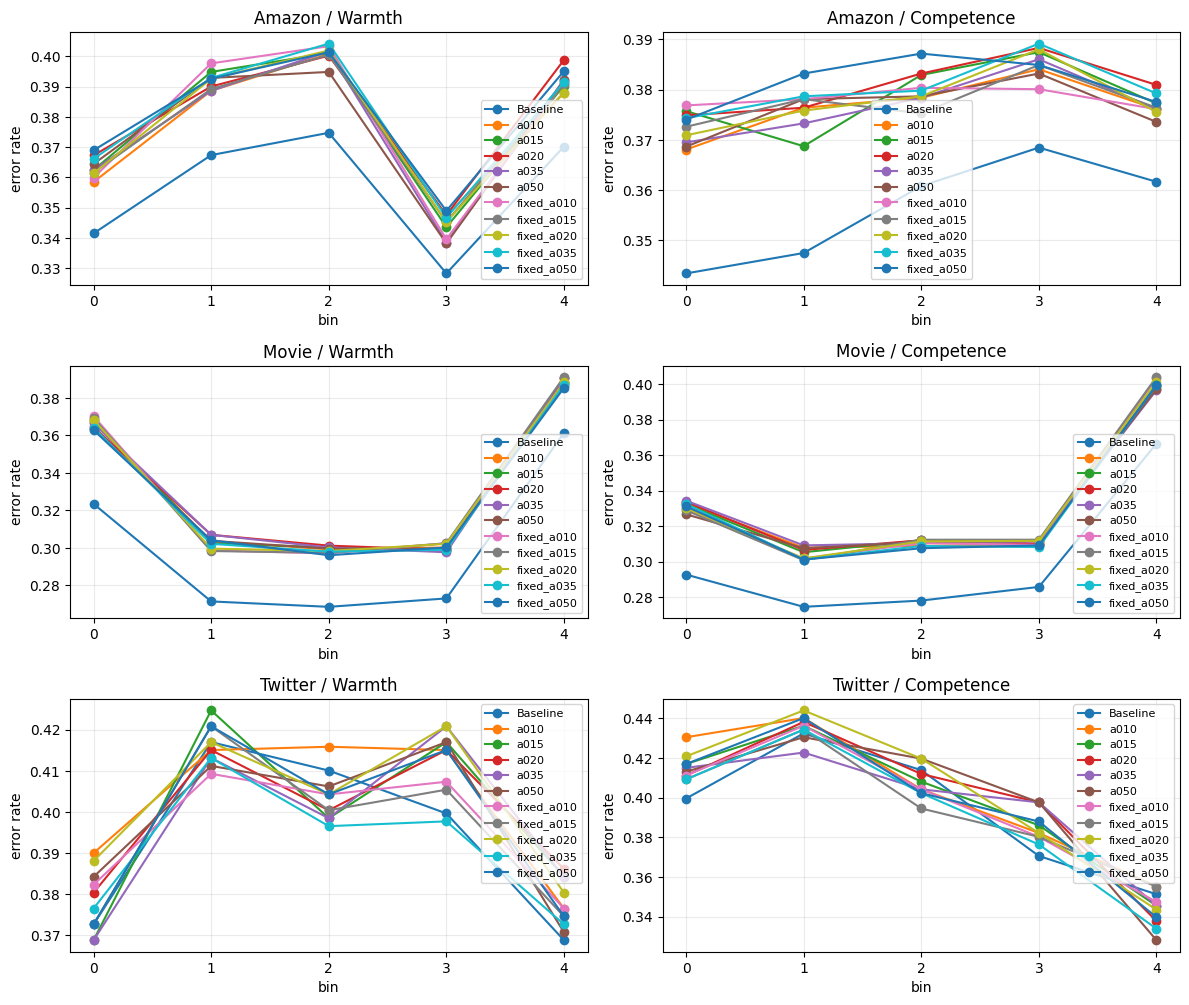

saved: /content/drive/MyDrive/SCM_Bias_Results/figures/diag_curves_all_8.png
saved: /content/drive/MyDrive/SCM_Bias_Results/figures/diag_metrics_8.csv


,dataset,axis,variant,accuracy,DP_gap,KS_p
0,Amazon,warmth_scm,Baseline,0.643614,0.011389,0.637172
1,Amazon,warmth_scm,a010,0.623377,0.014536,0.328800
2,Amazon,warmth_scm,a015,0.621563,0.018746,0.100377
3,Amazon,warmth_scm,a020,0.619239,0.012014,0.569161
4,Amazon,warmth_scm,a035,0.623321,0.018169,0.120287
5,Amazon,warmth_scm,a050,0.623547,0.018262,0.116878
6,Amazon,warmth_scm,fixed_a010,0.621677,0.020916,0.048327
7,Amazon,warmth_scm,fixed_a015,0.622527,0.015485,0.258688
8,Amazon,warmth_scm,fixed_a020,0.622187,0.018648,0.103560
9,Amazon,warmth_scm,fixed_a035,0.619749,0.018474,0.109379


In [ ]:
# Diagnostics Baseline vs All Debias Variants

DRIVE_PATH = "/content/drive/MyDrive/SCM_Bias_Results"
BASE_CKPT  = {
    "Amazon" : f"{DRIVE_PATH}/results_Amazon_ep2/checkpoint-2206",
    "Movie"  : f"{DRIVE_PATH}/results_Movie_ep3/checkpoint-2928",
    "Twitter": f"{DRIVE_PATH}/results_Twitter_ep5/checkpoint-810",
}
DEB_PATTERN = r"results_debiased_(?P<ds>\w+?)_(?P<tag>.+)"
DATASETS    = ["Amazon", "Movie", "Twitter"]
AXES        = ["warmth_scm", "competence_scm"]
SAVE_DIR    = os.path.join(DRIVE_PATH, "figures"); os.makedirs(SAVE_DIR, exist_ok=True)

MAX_LEN, INFER_BATCH, PINNED = 128, 512, True


@torch.inference_mode()
# Given a model and tokenizer, run inference on a list of texts, returns numpy array of logits.
def logits(model, tok, texts, desc):
    collate = lambda xs: tok(xs, truncation=True, padding=True,
                             max_length=MAX_LEN, return_tensors="pt")
    loader  = DataLoader(texts, batch_size=INFER_BATCH, shuffle=False,
                         collate_fn=collate, pin_memory=PINNED)

    outs = []
    with torch.amp.autocast("cuda", dtype=torch.float16):
        for bt in tqdm(loader, desc=desc, leave=False):
            bt = {k: v.to(device) for k, v in bt.items()}
            outs.append(model(**bt).logits.cpu())
    return torch.cat(outs).numpy()

def err_vec(logits, labels):
    return (logits.argmax(-1) != labels).astype(int)


# Compute demographic parity gap and KS-test p-value. Split by median of feature 'feat', if one side is empty, split by outer quantiles [q, 1-q]
def dp_ks(err, feat, q=.2):
    med = np.median(feat)
    lo, hi = err[feat<=med], err[feat>med]
    if lo.size*hi.size==0:
        lo_thr, hi_thr = np.quantile(feat,[q,1-q])
        lo, hi = err[feat<=lo_thr], err[feat>=hi_thr]
    if lo.size*hi.size==0: return np.nan,np.nan
    return abs(hi.mean()-lo.mean()), ks_2samp(hi,lo).pvalue

# Main Evaluation Loop
records, curve_buf, err_cache = [], {}, {}

for ds in tqdm(DATASETS, desc="Datasets"):
    df, txt = datasets[ds]["df"], datasets[ds]["text_col"]
    vidx    = all_results[ds]["test_idx"]
    texts   = (df.loc[vidx, txt]
              .fillna("")
              .astype(str)
              .tolist())
    labels  = (df.loc[vidx,"label_5class"]-1).values
    tok     = AutoTokenizer.from_pretrained(BASE_CKPT[ds], use_fast=True, local_files_only=True)

    # Compute baseline error vector
    model_b = AutoModelForSequenceClassification.from_pretrained(BASE_CKPT[ds]).to(device)
    err_b   = err_vec(logits(model_b, tok, texts, desc="infer-batch"), labels)
    err_cache[(ds,"Baseline")] = err_b
    del model_b; torch.cuda.empty_cache()

    # Identify all debiased variants for this dataset
    pat  = re.compile(DEB_PATTERN.replace(r"(?P<ds>\w+?)", ds))
    debs = [d for d in os.listdir(DRIVE_PATH) if pat.fullmatch(d)]
    variants = [("Baseline", BASE_CKPT[ds])] + [
        (pat.match(d).group("tag"),
         os.path.join(DRIVE_PATH,d,sorted(os.listdir(os.path.join(DRIVE_PATH,d)))[-1]))
        for d in sorted(debs)
    ]

    # Inference for each debiased variant, caching error vectors
    for tag, ckpt in tqdm(variants[1:], desc=f"{ds} variants", leave=False):
        model_d = AutoModelForSequenceClassification.from_pretrained(ckpt).to(device)
        err_d   = err_vec(logits(model_d, tok, texts, desc="infer-batch"), labels)
        err_cache[(ds,tag)] = err_d
        del model_d; torch.cuda.empty_cache()

    # Compute metrics and error-rate curves for each SCM axis
    for axis in AXES:
        feat  = df.loc[vidx, axis].values
        bins  = pd.qcut(pd.Series(feat).rank(method="first"), 5, labels=False)
        curves= {}
        for tag,_ in variants:
            err = err_cache[(ds,tag)]
            curves[tag] = pd.Series(err, index=bins).groupby(level=0).mean()
            records.append([ds,axis,tag, 1-err.mean(), *dp_ks(err,feat)])
        curve_buf[(ds,axis)] = curves

# Plotting and output csv
n_row,n_col=len(DATASETS),len(AXES)
fig,axarr=plt.subplots(n_row,n_col,figsize=(6*n_col,3.6*n_row),squeeze=False)
colors=cm.get_cmap("tab10").colors
for i,ds in enumerate(DATASETS):
    for j,axis in enumerate(AXES):
        ax=axarr[i][j]
        for k,(tag,series) in enumerate(curve_buf[(ds,axis)].items()):
            ax.plot(series.index,series.values,'o-',color=colors[k%10],label=tag)
        ax.set_title(f"{ds} / {axis.split('_')[0].title()}")
        ax.set_xlabel("bin"); ax.set_ylabel("error rate")
        ax.set_xticks(series.index); ax.grid(alpha=.25); ax.legend(fontsize=8)
fig.tight_layout(rect=[0,0,1,0.94])
png_path=os.path.join(SAVE_DIR,"diag_curves_all_8.png")
fig.savefig(png_path,dpi=300); plt.show(); print("saved:",png_path)

cols=["dataset","axis","variant","accuracy","DP_gap","KS_p"]
df_metrics=pd.DataFrame(records,columns=cols)
csv_path=os.path.join(SAVE_DIR,"diag_metrics_8.csv")
df_metrics.to_csv(csv_path,index=False)
print("saved:",csv_path)
display(df_metrics.head(12))


In [ ]:
# 16.Bootstrap + Sign-test

import os, re, warnings, numpy as np, pandas as pd, torch, hashlib, pickle
from scipy.stats import ks_2samp, binomtest
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          Trainer, TrainingArguments)

warnings.filterwarnings("ignore")


DRIVE    = "/content/drive/MyDrive/SCM_Bias_Results"
ALPHAS   = [0.10, 0.15, 0.20, 0.35, 0.50]
MAX_LEN  = 256

# Number of bootstrap samples for confidence intervals
B_BOOT   = 5_000



EVAL_PAIRS = [
    ("Amazon" , "competence_scm"),
    ("Amazon" , "warmth_scm"),
    ("Movie"  , "competence_scm"),
    ("Movie"  , "warmth_scm"),
    ("Twitter", "competence_scm"),
    ("Twitter", "warmth_scm"),
]


DEVICE   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SAVE_CSV = os.path.join(DRIVE, "significance_alpha_twins.csv")

# Dependency checks
for v in ("datasets", "all_results"):
    if v not in globals():
        raise RuntimeError("请先运行 baseline / debias 训练脚本，确保 datasets/all_results 已就绪。")

def latest_ckpt(folder:str)->str:
    if os.path.isfile(os.path.join(folder,"config.json")):
        return folder
    kids=[d for d in os.listdir(folder) if re.fullmatch(r"checkpoint-\d+",d)]
    if not kids:
        raise FileNotFoundError(f"No checkpoint- under {folder}")
    return os.path.join(folder,max(kids,key=lambda x:int(x.split('-')[1])))

def batch_encode(tok,texts,max_len=256,bs=1024):
    enc={'input_ids':[],'attention_mask':[]}
    for i in range(0,len(texts),bs):
        part=tok(texts[i:i+bs],truncation=True,padding='max_length',
                 max_length=max_len,return_tensors=None)
        enc['input_ids']+=part['input_ids']
        enc['attention_mask']+=part['attention_mask']
    return enc

class PlainDS(torch.utils.data.Dataset):
    def __init__(self,enc,lab): self.enc,self.lab=enc,lab
    def __len__(self): return len(self.lab)
    def __getitem__(self,i):
        d={k:torch.tensor(v[i]) for k,v in self.enc.items()}
        d['labels']=torch.tensor(self.lab[i]); return d

# In-memory and on-disk cache for error vectors to avoid recomputing
err_cache_mem = {}
ERR_CACHE_DIR = os.path.join(DRIVE, "_err_cache"); os.makedirs(ERR_CACHE_DIR, exist_ok=True)
def infer_err(ckpt,tok,dset,gold):
    key = f"{ckpt}|{tok.name_or_path}"
    if key in err_cache_mem:
        return err_cache_mem[key]

    h = hashlib.md5(key.encode()).hexdigest()
    pkl = os.path.join(ERR_CACHE_DIR, f"{h}.pkl")
    if os.path.isfile(pkl):
        with open(pkl,"rb") as f:
            err = pickle.load(f)
        err_cache_mem[key]=err; return err

    mdl = AutoModelForSequenceClassification.from_pretrained(ckpt).to(DEVICE)
    args= TrainingArguments("/tmp/_eval", per_device_eval_batch_size=256, report_to="none")
    pred= Trainer(mdl,args,tokenizer=tok).predict(dset).predictions.argmax(-1)
    err = (pred!=gold).astype(int)
    err_cache_mem[key]=err
    with open(pkl,"wb") as f: pickle.dump(err,f,protocol=4)
    return err

# Compute demographic parity gap
def dp_gap(err,feat,q=.2):
    med=np.median(feat)
    lo,hi=err[feat<=med],err[feat>med]
    if lo.size*hi.size==0:
        lo_t,hi_t=np.quantile(feat,[q,1-q])
        lo,hi=err[feat<=lo_t],err[feat>=hi_t]
    if lo.size*hi.size==0: return np.nan
    return abs(hi.mean()-lo.mean())

# Compute the p-value of a two-sample KS test
def ks_p(err,feat): return ks_2samp(feat[err==1],feat[err==0]).pvalue

# Compute bootstrap confidence interval
def boot_ci(arr,rng,B):
    boot=rng.choice(arr,size=(B,len(arr)),replace=True).mean(axis=1)
    return np.percentile(boot,[2.5,97.5])

# Bootstrap confidence interval for the difference
def dp_gap_ci(err_d,err_f,feat,rng,B):
    n=len(err_d); out=[]
    for _ in range(B):
        idx=rng.integers(0,n,n)
        out.append(dp_gap(err_d[idx],feat[idx])-dp_gap(err_f[idx],feat[idx]))
    return np.percentile(out,[2.5,97.5])

# Main Loop, evaluate each dataset–axis pair
tok_cache, ds_cache = {}, {}
rows=[]
rng_global=np.random.default_rng(42)

for ds_name,axis in EVAL_PAIRS:
    print(f"\n=== {ds_name}  {axis.split('_')[0].title()} ===")
    df      = datasets[ds_name]['df']
    textcol = datasets[ds_name]['text_col']
    idx_tst = all_results[ds_name]['test_idx']
    gold    = (df.loc[idx_tst,'label_5class']-1).values
    feat_all= df.loc[idx_tst,axis].values


    base_ckpt_guess = None
    base_ckpt_guess = [p for p in all_results[ds_name].keys() if "checkpoint" in str(p)]
    base_ckpt_guess = base_ckpt_guess[0] if base_ckpt_guess else None
    if base_ckpt_guess is None:
        for r,_,files in os.walk(DRIVE):
            if f"results_{ds_name}_" in r and "checkpoint-" in r and "config.json" in files:
                base_ckpt_guess=r; break

    # Tokenizer and Dataset caching
    if base_ckpt_guess not in tok_cache:
        tok_cache[base_ckpt_guess]=AutoTokenizer.from_pretrained(base_ckpt_guess,use_fast=True)
    tok=tok_cache[base_ckpt_guess]

    key=(ds_name,tok.name_or_path)
    if key not in ds_cache:
        enc=batch_encode(tok,df.loc[idx_tst,textcol].fillna("").astype(str).tolist(),MAX_LEN)
        ds_cache[key]=PlainDS(enc,gold)
    dset=ds_cache[key]

    # Baseline error vector and metrics
    err_base=infer_err(base_ckpt_guess,tok,dset,gold)
    acc_base=1-err_base.mean()
    dp_base =dp_gap(err_base,feat_all)
    ks_base =ks_p(err_base,feat_all)

    # Loop over each alpha for dynamic vs fixed debias comparison
    for alpha in ALPHAS:
        tag=f"a{int(alpha*100):03d}"
        dyn_dir=f"{DRIVE}/results_debiased_{ds_name}_{tag}"
        fix_dir=f"{DRIVE}/results_debiased_{ds_name}_fixed_{tag}"
        if not (os.path.isdir(dyn_dir) and os.path.isdir(fix_dir)):
            print(f"  α={alpha:.2f} loss ckpt, skip")
            continue

        err_dyn=infer_err(latest_ckpt(dyn_dir),tok,dset,gold)
        err_fix=infer_err(latest_ckpt(fix_dir),tok,dset,gold)

        # Accuracy and DP
        acc_dyn,acc_fix = 1-err_dyn.mean(),1-err_fix.mean()
        dp_dyn, dp_fix  = dp_gap(err_dyn,feat_all), dp_gap(err_fix,feat_all)
        ks_dyn, ks_fix  = ks_p(err_dyn,feat_all),  ks_p(err_fix,feat_all)

        # Differences
        d_acc = acc_dyn - acc_fix
        d_dp  = dp_dyn  - dp_fix
        d_ks  = ks_dyn  - ks_fix

        # Bootstrap confidence intervals
        rng=rng_global
        acc_ci_dyn = boot_ci(1-err_dyn,rng,B_BOOT)
        acc_ci_fix = boot_ci(1-err_fix,rng,B_BOOT)
        dp_ci_lo,dp_ci_hi = dp_gap_ci(err_dyn,err_fix,feat_all,rng,B_BOOT)

        # Safety ratio
        safety = np.abs(d_acc)/np.abs(d_dp) if (not np.isnan(d_dp) and d_dp!=0) else np.nan

        # Sign-test
        diff=err_fix-err_dyn
        n_pos=int((diff<0).sum())
        n_neg=int((diff>0).sum())
        p_sign=binomtest(n_pos,n_pos+n_neg,0.5).pvalue if (n_pos+n_neg) else 1.0

        rows.append([ds_name,axis,alpha,
                     f"{acc_dyn:.4f}",f"{acc_fix:.4f}",f"{d_acc:+.4f}",
                     f"{dp_dyn:.4f}",f"{dp_fix:.4f}",f"{d_dp:+.4f}",
                     f"{ks_dyn:.4f}",f"{ks_fix:.4f}",f"{d_ks:+.4f}",
                     f"{acc_ci_dyn[0]:.4f}",f"{acc_ci_dyn[1]:.4f}",
                     f"{dp_ci_lo:.4f}",f"{dp_ci_hi:.4f}",
                     f"{safety:.4f}",
                     n_pos,n_neg,f"{p_sign:.4f}"])

# Output
cols=["dataset","axis","alpha",
      "Acc_dyn","Acc_fix","ΔAcc",
      "DP_dyn","DP_fix","ΔDP",
      "KS_dyn","KS_fix","ΔKS",
      "AccDyn_lo","AccDyn_hi","ΔDP_lo","ΔDP_hi",
      "Safety","n_dyn_better","n_dyn_worse","p_sign"]
out=pd.DataFrame(rows,columns=cols)

pd.set_option('display.max_columns',None)
pd.set_option('display.precision',4)
print("\n===== Bootstrap + Sign-test  =====")
print(out.to_string(index=False))

out.to_csv(SAVE_CSV,index=False)
print(f"\nCSV saved to {SAVE_CSV}")



=== Amazon   Competence ===



=== Amazon   Warmth ===

=== Movie   Competence ===



=== Movie   Warmth ===

=== Twitter   Competence ===



=== Twitter  Warmth ===

=====  Bootstrap + Sign-test  =====
dataset           axis  alpha Acc_dyn Acc_fix    ΔAcc DP_dyn DP_fix     ΔDP KS_dyn KS_fix     ΔKS AccDyn_lo AccDyn_hi  ΔDP_lo  ΔDP_hi Safety  n_dyn_better  n_dyn_worse p_sign
 Amazon competence_scm   0.10  0.6302  0.6293 +0.0010 0.0012 0.0015 -0.0003 0.9998 0.9977 +0.0022    0.6230    0.6375 -0.0086  0.0082 3.0355           539          556 0.6287
 Amazon competence_scm   0.15  0.6291  0.6301 -0.0010 0.0025 0.0009 +0.0016 0.9272 0.6895 +0.2376    0.6219    0.6362 -0.0071  0.0082 0.6059           574          557 0.6343
 Amazon competence_scm   0.20  0.6268  0.6302 -0.0034 0.0007 0.0034 -0.0027 0.9999 0.6357 +0.3642    0.6196    0.6336 -0.0088  0.0078 1.2655           622          562 0.0864
 Amazon competence_scm   0.35  0.6301  0.6276 +0.0025 0.0012 0.0028 -0.0016 0.9917 0.8778 +0.1139    0.6230    0.6373 -0.0087  0.0077 1.5144           626          670 0.2323
 Amazon competence_scm   0.50  0.6309  0.6253 +0.0056 0.0004 0.